# Downscaling of 2m temperature from IFS HRES with a U-Net


## Introduction


### The task

To obtain information on the atmospheric state with ever increasing detail, the grid spacing in contemporary numerical weather prediction models is increased continuously. However, due to the related enormous computational costs, but also due to the design of these models, further increasing the spatial resolution is not straightforward and usually even not feasible operationally (e.g. a global model with 1 km grid spacing). 
Thus, alternative approaches have been developed to enhance the spatial resolution of (tailor-made) predictions which is commonly referred as statistical downscaling. The task in this dataset is to develop a U-net, a subvariant of a neural network, that is capable to do this job.

### The proof-of-concept application (Tier-1)

Here, we follow a simplified approach where we emulate the downscaling task by coarsening IFS HRES analysis data beforehand to come up with a coarse-grained NWP product. The U-net will then be trained to reproduce the original data field at higher spatial resolution. As this is a proof-of-concept application, only the most essential predictors are involved here, that are the surface elevation and the 2m temperature obtained from the coarsened NWP output. The reconstruction of the latter, the 2m temperature, at the original resolution also constitutes the objective here.

More details on the dataset and the preprocessing is provided below.

### Prerequisites <b>(technical)</b>

To obtain the data, to run the training and to visualize (=plot) the downscaled product, a customized Jupyter kernel must be set-up. Further details to create such a kernel a provided in `downscaling_unet_jupyter_kernel.md` under the `config_hpc`-directory. <br>
Besides, it is worth to noteworthy that the data can only be downloaded when running on the login nodes. The computing nodes used for training are not connected to the internet and therefore must obtain the data being downloaded and stored on scratch beforehand. The steps to be executed on the login node are highlighted in the following.

## Retrieving the data <b>(required, login node!)</b>
For convenient data retrieval, we make use of the `climetlab`-package. In particular, a specific package based on `climetlab` for this first application has been set-up (Tier-1 dataset). Thus, we start with importing the packages:

In [ ]:
import os
import climetlab as cml
import xarray as xr

To obtain data from the s3bucket for training the U-net (to be defined later), we simply submit the following request:

In [ ]:
cmlds_train = cml.load_dataset("maelstrom-downscaling", dataset="training")
cmlds_val = cml.load_dataset("maelstrom-downscaling", dataset="validation")
cmlds_test = cml.load_dataset("maelstrom-downscaling", dataset="testing")

The testing dataset can be downloaded by changing the `dataset`-argument to `"testing"`. <br>
Alternatively, data can be requested by passing a list of months with the `months` keyword. <br>
All available months can be listed by:

In [ ]:
print(cmlds_train.all_datelist)

The downloaded data can be easily converted to convenient xarray-datasets applying the method  `to_xarray()`. Besides, we must save the data on scratch for the training process. We store the data into netCDF-files into a user-defined directory which must be accessible for the computing nodes (e.g. directories under `/p/project/<...>/`).

In [ ]:
# convert to xarray datasets
ds_train = cmlds_train.to_xarray()
ds_val = cmlds_val.to_xarray()
ds_test = cmlds_test.to_xarray()

# peek training data
print(ds_train)

# store data into netCDF-files
# auxiliary function
def ds_to_netcdf(ds: xr.Dataset, fname: str, comp_lvl=5):
    """
    Create dictionary for compressing all variables of dataset in netCDF-files
    :param ds: the xarray-dataset
    :param fname: name of the target netCDF-file
    :param comp_lvl: the compression level
    :return: True in case of success
    """
    method = ds_to_netcdf.__name__
    comp = dict(zlib=True, complevel=5)
    try:
        encoding_ds = {var: comp for var in ds.data_vars}
        print("%{0}: Save dataset to netCDF-file '{1}'".format(method, fname))
        ds_train.to_netcdf(path=fname, encoding=encoding_ds)#, engine="scipy")
    except Exception as err:
        print("%{0}: Failed to handle and save input dataset.".format(method))
        raise err
    
    return True

# action
datadir = "/p/project/deepacf/maelstrom/data/downscaling_unet/"
nc_base = "downscaling_unet"
ncf_train, ncf_val, ncf_test = os.path.join(datadir, nc_base+"_train.nc"), os.path.join(datadir, nc_base+"_val.nc"), \
                               os.path.join(datadir, nc_base+"_test.nc")

_, _, _ = ds_to_netcdf(ds_train, ncf_train), ds_to_netcdf(ds_val, ncf_val), ds_to_netcdf(ds_test, ncf_test)

### Retrieving the data <b>(required, computing node!)</b>

Getting the data on the computing node requires that the data retrieval on the login node has been done beforehand.
Having done so, we simply read the netCDF-files from scratch. <br>
We start with loading the required xarray-package...

In [1]:
import os
import numpy as np
import xarray as xr

... and continue with reading the data into memory. Note, that the `datadir`-variable must be set according to its counterpart on the login node (see above).

In [2]:
datadir = "/p/project/deepacf/maelstrom/data/downscaling_unet/"
nc_base = "downscaling_unet"
ncf_train, ncf_val, ncf_test = os.path.join(datadir, nc_base+"_train.nc"), os.path.join(datadir, nc_base+"_val.nc"), \
                               os.path.join(datadir, nc_base+"_test.nc")

ds_train, ds_val, ds_test = xr.open_dataset(ncf_train), xr.open_dataset(ncf_val), xr.open_dataset(ncf_test)

# print ds_train for double-checking
ds_train

<xarray.Dataset>
Dimensions:  (time: 1464, lon: 128, lat: 96)
Coordinates:
  * time     (time) datetime64[ns] 2016-04-01 ... 2019-09-30T12:00:00
  * lon      (lon) float64 4.0 4.1 4.2 4.3 4.4 4.5 ... 16.3 16.4 16.5 16.6 16.7
  * lat      (lat) float64 54.5 54.4 54.3 54.2 54.1 ... 45.4 45.3 45.2 45.1 45.0
Data variables:
    t2m_in   (time, lat, lon) float64 ...
    z_in     (time, lat, lon) float64 ...
    z_tar    (time, lat, lon) float64 ...
    t2m_tar  (time, lat, lon) float64 ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    Conventions:                CF-1.6
    history:                    Mon Aug 02 21:00:13 2021: cdo mergetime 2016/...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    history_of_appended_files:  Mon Aug  2 20:54:16 2021: Appended file /p/sc...
    CDO:                        Climate Data Operators version 1.9.8 (https:/...

### Details on the data (additional information)

- Input variables are denoted with the suffix `_in`, whereas the target, output variables carry `_tar` as suffix
- The data is given at the analysis time of the IFS HRES model, that is at 00 UTC and 12 UTC. Besides, the data coverage is limited to the summer season defined as the period between April and September, inclusively
- Spatially, the data is given on a limited domain over Central Europe with 128x96 grid points in zonal and meridional direction, respectively
- The underlying spherical grid is the same for the input and output data as suggested by Sha et al., 2020 [1] for their U-net. However the information content differs: 
    - While the output data is directly obtained from the IFS HRES data (with only slight remapping onto a regular spherical grid), the input data has been preprocessed as follows:
    - coarsening onto a grid whose spacing is eight times larger than the original data via conservative remapping using CDO [2]
    - bilinear interpolation back onto the original grid 
- Note that the first step removes the spatial variability of the data on spatial scales smaller than the coarse-grained grid spacing. This step cannot be reverted via bilinear interpolation and therefore imitates effectively a model configuration of IFS HRES whose grid spacing is larger by a factor of eight than the original one

The latter statement can be illustrated by plotting both meteorological data fields, the input and target 2m temperature.
<br><br>
[1] Sha, Yingkai, et al. "Deep-learning-based gridded downscaling of surface meteorological variables in complex terrain. Part I: Daily maximum and minimum 2-m temperature." Journal of Applied Meteorology and Climatology 59.12 (2020): 2057-2073. <a href="https://doi.org/10.1175/JAMC-D-20-0057.1">DOI</a> <br>
[2] Schulzweida, Uwe. (2019, October 31). CDO User Guide (Version 1.9.8). <a href="http://doi.org/10.5281/zenodo.3539275">DOI</a>

### Plotting the data (additional information)

First, we define some auxiliary functions. If you are not interested in the details of the plotting procedure, you may skip the following cells. However, don't forget to run it, so that the routines become available.

In [3]:
# get the hostname (to suppress querying border- and coaslines on computing nodes without web access)
host = os.getenv('HOSTNAME')
# for plotting
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# for querying dictionary
def provide_default(dict_in, keyname, default=None, required=False):
    """
    Returns values of key from input dictionary or alternatively its default

    :param dict_in: input dictionary
    :param keyname: name of key which should be added to dict_in if it is not already existing
    :param default: default value of key (returned if keyname is not present in dict_in)
    :param required: Forces existence of keyname in dict_in (otherwise, an error is returned)
    :return: value of requested key or its default retrieved from dict_in
    """

    if not required and default is None:
        raise ValueError("Provide default when existence of key in dictionary is not required.")
        
    if keyname not in dict_in.keys():
        if required:
            print(dict_in)
            raise ValueError("Could not find '{0}' in input dictionary.".format(keyname))
        return default
    else:
        return dict_in[keyname]

# auxiliary function for colormap
def get_colormap_temp(levels = None):
    """
    Get a nice colormap for plotting topographic height
    :param levels: level boundaries
    :return cmap: colormap-object
    :return norm: normalization object corresponding to colormap and levels
    """
    bounds = np.asarray(levels)
        
    nbounds = len(bounds)
    col_obj = mpl.cm.PuOr_r(np.linspace(0., 1., nbounds))
    
    # create colormap and corresponding norm
    cmap = mpl.colors.ListedColormap(col_obj, name="temp" + "_map")
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)    
    
    return cmap, norm, bounds

# for making plot nice
def decorate_plot(ax_plot, plot_xlabel=True, plot_ylabel=True):
        
    fs = 16
    if "login" in host:
        # add nice coast- and borderlines
        ax_plot.coastlines(linewidth=0.75)
        ax_plot.coastlines(linewidth=0.75)
        ax_plot.add_feature(cartopy.feature.BORDERS)
        
    # adjust extent and ticks as well as axis-label
    ax_plot.set_xticks(np.arange(0., 360. + 0.1, 5.))  # ,crs=projection_crs)
    ax_plot.set_yticks(np.arange(-90., 90. + 0.1, 5.))  # ,crs=projection_crs)

    ax_plot.set_extent([3.5, 17., 44.5, 55.])#, crs=prj_crs)
    ax_plot.minorticks_on()
    ax_plot.tick_params(axis="both", which="both", direction="out", labelsize=12)

    # some labels
    if plot_xlabel:
        ax_plot.set_xlabel("Longitude [°E]", fontsize=fs)
    if plot_ylabel:
        ax_plot.set_ylabel("Latitude[°N]", fontsize=fs)
    
    return ax_plot

# for creating plot
def create_plots(data1, data2, opt_plot={}):
    
    # get coordinate data 
    try:
        time, lat, lon = data1["time"].values, data1["lat"].values, data1["lon"].values
        time_stamp = (pd.to_datetime(time)).strftime("%Y-%m-%d %H:00 UTC")
    except Exception as err:
        print("Failed to retrieve coordinates from data1")
        raise err
    # construct array for edges of grid points
    dy, dx = np.round((lat[1] - lat[0]), 2), np.round((lon[1] - lon[0]), 2)
    lat_e, lon_e = np.arange(lat[0]-dy/2, lat[-1]+dy, dy), np.arange(lon[0]-dx/2, lon[-1]+dx, dx)
    
    title1, title2 = provide_default(opt_plot, "title1", "input T2m"), provide_default(opt_plot, "title2", "target T2m")
    title1, title2 = "{0}, {1}".format(title1, time_stamp), "{0}, {1}".format(title2, time_stamp)
    levels = provide_default(opt_plot, "levels", np.arange(-5., 25., 1.))
    
    # get colormap
    cmap_temp, norm_temp, lvl = get_colormap_temp(levels)
    # create plot objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
    
    # perform plotting
    temp1 = ax1.pcolormesh(lon_e, lat_e, np.squeeze(data1.values-273.15), cmap=cmap_temp, norm=norm_temp)
    temp2 = ax2.pcolormesh(lon_e, lat_e, np.squeeze(data2.values-273.15), cmap=cmap_temp, norm=norm_temp)

    ax1, ax2 = decorate_plot(ax1), decorate_plot(ax2, plot_ylabel=False) 

    ax1.set_title(title1, size=14)
    ax2.set_title(title2, size=14)

    # add colorbar
    cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cbar = fig.colorbar(temp2, cax=cax, orientation="vertical", ticks=lvl[1::2])
    cbar.ax.tick_params(labelsize=12)

The following cell produces a plot of the input 2m temperature which was coarsened during preprocessing (left) and the target temperature field. You may play around with `tind` to select different times.

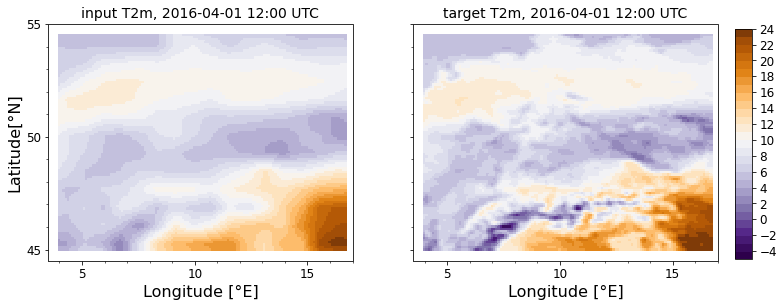

In [4]:
# even time indices yield 00 UTC, odd yield 12 UTC
tind = 1

create_plots(ds_train["t2m_in"].isel(time=tind), ds_train["t2m_tar"].isel(time=tind))

Note that the input data shows up wit a very smooth temperature field, whereas the target 2m temperature is variable in the presence of complex topography (Alps and Low-mountain range), but also near the coastal areas (e.g. Netherlands).

## Build and train a U-net for downscaling (required)

<b> Note: </b> From this step on, everything should be executed on the <b>computing node</b>. <br>

Before building the specific U-net, we need to define some auxiliary functions that wrap the building blocks of the model architecture. Again, you may skip digging into the details, but you must, of course, run the cell to enable building the model architecture.

In [5]:
# import tensorflow and required stuff from Keras API
import tensorflow as tf

# all the layers used for U-net
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D
)
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters: int, kernel: tuple = (3,3), padding: str = "same",
               activation: str = "relu", kernel_init: str = "he_normal", l_batch_normalization: bool = True):
    """
    A convolutional layer with optional batch normalization
    :param inputs: the input data with dimensions nx, ny and nc
    :param num_filters: number of filters (output channel dimension)
    :param kernel: tuple indictating kernel size
    :param padding: technique for padding (e.g. "same" or "valid")
    :param activation: activation fuction for neurons (e.g. "relu")
    :param kernel_init: initialization technique (e.g. "he_normal" or "glorot_uniform")
    """
    
    x = Conv2D(num_filters, kernel, padding=padding, kernel_initializer=kernel_init)(inputs)
    if l_batch_normalization:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x

def conv_block_n(inputs, num_filters, n=2, kernel=(3,3), padding="same", activation="relu", 
                     kernel_init="he_normal", l_batch_normalization=True):
    """
    Sequential application of two convolutional layers (using conv_block).
    """
    
    x = conv_block(inputs, num_filters, kernel, padding, activation,
                   kernel_init, l_batch_normalization)
    for i in np.arange(n-1):
        x = conv_block(x, num_filters, kernel, padding, activation,
                       kernel_init, l_batch_normalization)
    
    return x

def encoder_block(inputs, num_filters, kernel_maxpool: tuple=(2,2), l_large: bool=True):
    """
    One complete encoder-block used in U-net
    """
    if l_large:
        x = conv_block_n(inputs, num_filters, n=2)
    else:
        x = conv_block(inputs, num_filters)
        
    p = MaxPool2D(kernel_maxpool)(x)
    
    return x, p

def decoder_block(inputs, skip_features, num_filters, kernel: tuple=(3,3), strides_up: int=2, padding: str= "same", 
                  activation="relu", kernel_init="he_normal", l_batch_normalization: bool=True):
    """
    One complete decoder block used in U-net (reverting the encoder)
    """
    
    x = Conv2DTranspose(num_filters, (strides_up, strides_up), strides=strides_up, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_n(x, num_filters, 2, kernel, padding, activation, kernel_init, l_batch_normalization)
    
    return x

2021-11-23 14:09:40.214398: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


The following cell creates the function to build up the U-net following the architecture used in the study by Sha et al. 2020 [1]. <br>
Note, that an additional output branch for the surface elevation can be activated.
This output branch helps the network to extract meaningful features of the topography and is therefore considered to enhance the generalization capacities as argued in [1]. Likewise, it would allow an transfer learning approach to regions where now high-resolved 2m temperature data is available for training.<br><br>
[1]: Sha, Yingkai, et al. "Deep-learning-based gridded downscaling of surface meteorological variables in complex terrain. Part I: Daily maximum and minimum 2-m temperature." Journal of Applied Meteorology and Climatology 59.12 (2020): 2057-2073. (<a href="https://doi.org/10.1175/JAMC-D-20-0057.1">DOI</a>)

In [6]:
def build_unet(input_shape, channels_start=56, z_branch=False):
    
    inputs = Input(input_shape)
    
    """ encoder """
    s1, e1 = encoder_block(inputs, channels_start, l_large=True)
    s2, e2 = encoder_block(e1, channels_start*2, l_large=False)
    s3, e3 = encoder_block(e2, channels_start*4, l_large=False)
    
    """ bridge encoder <-> decoder """
    b1 = conv_block(e3, channels_start*8)
    
    """ decoder """
    d1 = decoder_block(b1, s3, channels_start*4)
    d2 = decoder_block(d1, s2, channels_start*2)
    d3 = decoder_block(d2, s1, channels_start)
    
    output_temp = Conv2D(1, (1,1), kernel_initializer="he_normal", name="output_temp")(d3)
    if z_branch:
        output_z = Conv2D(1, (1, 1), kernel_initializer="he_normal", name="output_z")(d3)

        model = Model(inputs, [output_temp, output_z], name="t2m_downscaling_unet_with_z")
    else:    
        model = Model(inputs, output_temp, name="t2m_downscaling_unet")
    
    return model

Let's build and visualize the model architecture. For conveninece, we predescribe the input size of the data.

In [10]:
import tensorflow.keras.utils as ku
shape_in = (96, 128, 3)

if "login" in host:
    unet_model = build_unet(shape_in, z_branch=True)
    ku.plot_model(unet_model, show_shapes=True)

Next, we need to preprocess the data which we obtained from the database. <br>
Here, we make use of the z-score normalization to project the data onto a value range which eases backpropagation. Besides, we limit the data to a particluar datetime. This is reasonable in the scope of this approach, since no further information on the atmospheric state is offered to the model, e.g. atmospheric stratification in the planetary boundary layer (PBL). <br>
By slicing the data for 12 UTC only, it is ensured that the PBL is usually well mixed during summertimes. However, you may also try training with data from 00 UTC (at night). <br><br>
Again we start by defining some further helper functions:

In [7]:
import datetime as dt

def preprocess_data_for_unet(dataset, daytime=12, opt_norm={}):
    """
    Preprocess the data for feeding into the U-net, i.e. conversion to data arrays incl. z-score normalization
    :param dataset: the dataset obtained from the database
    :param daytime: daytime in UTC for temporal slicing
    :param opt_norm: dictionary holding data for z-score normalization of data ("mu_in", "std_in", "mu_tar", "std_tar")
    :return: normalized data ready to be fed to U-net model
    """
    norm_dims_t = ["time"]                   # normalization of 2m temperature for each grid point
    norm_dims_z = ["time", "lat", "lon"]     # 'global' normalization of surface elevation
    
    # slice the dataset
    dsf = dataset.sel(time=dt.time(daytime))
    
    # retrieve and normalize input and target data
    if not opt_norm:
        t2m_in, t2m_in_mu, t2m_in_std  = z_norm_data(dsf["t2m_in"], dims=norm_dims_t, return_stat=True)
        t2m_tar, t2m_tar_mu, t2m_tar_std = z_norm_data(dsf["t2m_tar"], dims=norm_dims_t, return_stat=True)
    else: 
        t2m_in = z_norm_data(dsf["t2m_in"], mu=opt_norm["mu_in"], std=opt_norm["std_in"])
        t2m_tar = z_norm_data(dsf["t2m_tar"], mu=opt_norm["mu_tar"], std=opt_norm["std_tar"])
        
    z_in, z_tar = z_norm_data(dsf["z_in"], dims=norm_dims_z), z_norm_data(dsf["z_tar"], dims=norm_dims_z)

    in_data = xr.concat([t2m_in, z_in, z_tar], dim="variable")
    tar_data = xr.concat([t2m_tar, z_tar], dim="variable")

    # re-order data
    in_data = in_data.transpose("time",...,"variable")
    tar_data = tar_data.transpose("time",...,"variable")
    if not opt_norm:
        opt_norm = {"mu_in": t2m_in_mu, "std_in": t2m_in_std,
                    "mu_tar": t2m_tar_mu, "std_tar": t2m_tar_std}
        return in_data, tar_data, opt_norm
    else:
        return in_data, tar_data
    

def z_norm_data(data, mu=None, std=None, dims=None, return_stat=False):
    """
    Perform z-score normalization on the data
    :param data: the data-array
    :param mu: the mean used for normalization (set to False if calculation from data is desired)
    :param std: the standard deviation used for normalization (set to False if calculation from data is desired)
    :param dims: list of dimension over which statistical quantities for normalization are calculated
    :param return_stat: flag if normalization statistics are returned
    :return: the normalized data
    """
    if mu is None and std is None:
        if not dims:
            dims = list(data.dims)
        mu = data.mean(dim=dims)
        std = data.std(dim=dims)
        
    data_out = (data-mu)/std
    
    if return_stat:
        return data_out, mu, std
    else:
        return data_out    

Now, let's preprocess the training data. Change hour to 0 if you would like to train a U-net for nightly conditions.

In [11]:
hour = 12

int_data, tart_data, opt_norm = preprocess_data_for_unet(ds_train, daytime=hour)
inv_data, tarv_data = preprocess_data_for_unet(ds_val, daytime=hour, opt_norm=opt_norm)

# infer the shape of the data
shape_in_data = int_data.shape
assert shape_in_data[1:] == shape_in, "Shape of preprocessed data ({0}) differs from expected shape ({1})."\
                                      .format(shape_in_data, shape_in)

Having preprocessed the training data, we are ready to compile and train the U-net. <br>
The U-net produces good results when it is trained for 30 epochs. Thereby, the leraning rate gets decayed exponentially after 5 epochs using a learning rate scheduler that is passed to the model via Keras callback-functionality.

### Start training (required)
We are now ready to start the training. The optimization makes use of the Adam-optimizer and learning rate decay is deployed between the epoch 5 and 30. In total, we train for 50 epochs with a batch-size of 32 training samples.
By default, training on the z_branch is enabled to make the model learn abstractions of the underlying topography.

In [20]:
from tensorflow.keras.optimizers import Adam

z_branch = True                    # flag if additionally training on surface elevation is performed

# define a earning-rate scheduler
def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  elif epoch >= 5 and epoch < 30:
    return lr * tf.math.exp(-0.1)
  elif epoch >= 30:
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# build, compile and train the model
unet_model = build_unet(shape_in, z_branch=z_branch)
if z_branch:
    unet_model.compile(optimizer=Adam(learning_rate=5*10**(-4)),
                   loss={"output_temp": "mae", "output_z": "mae"}, 
                   loss_weights={"output_temp": 1.0, "output_z": 1.0})
    
    history = unet_model.fit(x=int_data.values, y={"output_temp": tart_data.isel(variable=0).values,
                                                   "output_z": tart_data.isel(variable=1).values},
                             batch_size=32, epochs=70, callbacks=[callback], 
                             validation_data=(inv_data.values, {"output_temp": tarv_data.isel(variable=0).values,
                                                                "output_z": tarv_data.isel(variable=1).values}))
else:
    unet_model.compile(optimizer=Adam(learning_rate=5*10**(-4)), loss="mae")

    history = unet_model.fit(x=int_data.values, y=tart_data.isel(variable=0).values, batch_size=32,
                             epochs=70, callbacks=[callback],
                             validation_data=(inv_data.values, tarv_data.isel(variable=0).values))

Epoch 1/70
23/23 [==============================] - 4s 107ms/step - loss: 0.6917 - output_temp_loss: 0.3540 - output_z_loss: 0.3376 - val_loss: 9.7144 - val_output_temp_loss: 2.8950 - val_output_z_loss: 6.8194
Epoch 2/70
23/23 [==============================] - 2s 85ms/step - loss: 0.3412 - output_temp_loss: 0.2495 - output_z_loss: 0.0917 - val_loss: 3.5352 - val_output_temp_loss: 1.1563 - val_output_z_loss: 2.3790
Epoch 3/70
23/23 [==============================] - 2s 85ms/step - loss: 0.2450 - output_temp_loss: 0.1834 - output_z_loss: 0.0615 - val_loss: 1.4393 - val_output_temp_loss: 0.5720 - val_output_z_loss: 0.8674
Epoch 4/70
23/23 [==============================] - 2s 85ms/step - loss: 0.2709 - output_temp_loss: 0.2156 - output_z_loss: 0.0553 - val_loss: 0.7989 - val_output_temp_loss: 0.2642 - val_output_z_loss: 0.5346
Epoch 5/70
23/23 [==============================] - 2s 85ms/step - loss: 0.2620 - output_temp_loss: 0.2047 - output_z_loss: 0.0572 - val_loss: 0.6001 - val_output_

## Taking a look at the results (required)

<b>Note:</b> This step is recommended since we check the success of the training here. The training is considered to be successful when ...<br> 

Having trained our U-net model, let's have a look at the results. <br>
In the following, we will produce downscaled 2m temperature fields for the validation or testing datasets. 
Both datasets have not been part (explictly) of the optimization and can therefore be used for verifying the success of our training.

In [21]:
# preprocess the test data first
inte_data, tarte_data = preprocess_data_for_unet(ds_test, daytime=hour, opt_norm=opt_norm)

# generate the downscaled fields
y_pred_val = unet_model.predict(inv_data.values, verbose=1)
y_pred_test = unet_model.predict(inte_data.values, verbose=1)

23/23 [==============================] - 0s 17ms/step


In [22]:
comparison_type = "test"            # change here to switch between validation and testing data
if comparison_type == "validation":
  y_pred = y_pred_val
  ds_ref = ds_val.sel(time=dt.time(hour))
  var_ref = tarv_data.isel(variable=0)
elif comparison_type == "test":
  y_pred = y_pred_test
  ds_ref = ds_test.sel(time=dt.time(hour))
  var_ref = tarte_data.isel(variable=0)
else:
  ValueError("Unknown comparison_type '{0}' chosen.".format(comparison_type))

if np.ndim(y_pred) == 5:                # cropping necessary if z_branch is True (two output channels)
  y_pred = y_pred[0]
else:
  pass

The data is still normalized and thus must be denormalized first. <br> 
For this purpose, we can exploit the `opt_norm`-dictionary created above.

In [23]:
# get some relevant information from the original dataset, ...
coords = var_ref.squeeze().coords
dims = var_ref.squeeze().dims

# denomralize...
y_pred_trans = np.squeeze(y_pred)*opt_norm["std_tar"].squeeze().values + opt_norm["mu_tar"].squeeze().values
# and make xarray DataArray 
y_pred_trans = xr.DataArray(y_pred_trans, coords=coords, dims=dims)

First let's a perform a simple verification by calculating the MSE (the MSE should be about/below 0.40 K**2):

In [24]:
mse = ((y_pred_trans - ds_ref["t2m_tar"])**2).mean(dim=["lat", "lon"])

print("MSE of downscaled 2m temperature: {0:.3f} K**2 (+/-{1:.3f} K**2)".format(mse.mean().values, mse.std().values))

MSE of downscaled 2m temperature: 0.374 K**2 (+/-0.114 K**2)


To create the plots, we can use the `create_plots`-function defined above. The optional dictionary `opt_plot` helps to customize their appearance.

In [ ]:
# choose a time index
tind = 0

# plot the full 2m temperature
create_plots(y_pred_trans.isel(time=tind), ds_ref["t2m_in"].isel(time=tind),
             opt_plot={"title1": "downscaled T2m", "title2": "input T2m"})
create_plots(y_pred_trans.isel(time=tind), ds_ref["t2m_tar"].isel(time=tind),
             opt_plot={"title1": "downscaled T2m"})
# plot differences
diff_in_tar = ds_ref["t2m_in"].isel(time=tind)-ds_ref["t2m_tar"].isel(time=tind) + 273.15
diff_down_tar = y_pred_trans.isel(time=tind)-ds_ref["t2m_tar"].isel(time=tind) + 273.15
create_plots(diff_in_tar, diff_down_tar,
             opt_plot={"title1": "diff. input-target", "title2": "diff. downscaled-target",
                       "levels": np.arange(-3., 3.1, .2)})

As we see, the model has learned to recover a lot of details resulting mainly from the topography. Especially over the Alpes, but also over the the German low mountain ranges, the differences have become smaller and less structured. It is also noted that the differences near the coast (e.g. at the Baltic Sea) have become smaller. <br>
However, some systematic features are still visible, the differences can stilll be as large as 3 K and especially in the Alps, the differences are somehow 'blurry'. Thus, there is still room for further improvement. 
These improvements will not only pertain the model architecture, but will also target to engulf more meteorological variables. The latter will also enable the network to generalize with respect to daytime and season. Note, that this has not been done yet, since we trained the U-net with data between April and September at 12 UTC only.
 